# Internações Respiratórias RJ — Pipeline e Análise Exploratória (SUS 2012–2024)

Este notebook consolida as **internações por doenças respiratórias** (SUS) no **município do Rio de Janeiro** e prepara a **série diária de internações** para modelagem.
O foco é: leitura dos dados brutos anuais, filtros clínicos e geográficos coerentes com exposição ambiental e uma **análise exploratória inicial**.

> **Escopo**: 2012–2024, diagnósticos respiratórios (CID-10 selecionados), residentes do Rio (IBGE 330455) e permanência hospitalar > 0.

## Objetivos desta etapa
1. **Carregar** todos os CSVs anuais (2012–2024) diretamente do GitHub (*raw*).
2. **Padronizar** campos-chave (datas, CID-10) e **filtrar** registros de interesse.
3. **Construir** a série **diária** de internações (`data_dia` × `internacoes`).
4. **Explorar** o comportamento da série (tendência, sazonalidade, distribuição) e variáveis-chave (idade, permanência).
5. **Salvar** a série diária para uso posterior na modelagem.

## Configurações e importações
Bibliotecas usadas e parâmetros gerais.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.stattools import acf
from scipy.signal import periodogram
from numpy.linalg import lstsq
from __future__ import annotations
import numpy as np
import pandas as pd

pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)
plt.rcParams["figure.figsize"] = (12, 5)
plt.rcParams["axes.grid"] = True

## Carregamento e Unificação das Estações

Nesta etapa:

- **Origem:** `data/datasus/Ano/dados_filtrados_{ANO}.csv` (2012–2024) no branch `refs/heads/main`.
- **Concatenação:** une todos os anos com `ignore_index=True`.

In [2]:
anos = range(2012, 2025)
tpl = "https://raw.githubusercontent.com/AILAB-CEFET-RJ/qualiar/refs/heads/main/data/datasus/Ano/dados_filtrados_{ano}.csv"

dfs = []
for ano in anos:
    url = tpl.format(ano=ano)
    print(f"Lendo: {url}")
    df = pd.read_csv(url, encoding="utf-8")
    df["ano_arquivo"] = ano
    dfs.append(df)

df_sus = pd.concat(dfs, ignore_index=True)

Lendo: https://raw.githubusercontent.com/AILAB-CEFET-RJ/qualiar/refs/heads/main/data/datasus/Ano/dados_filtrados_2012.csv
Lendo: https://raw.githubusercontent.com/AILAB-CEFET-RJ/qualiar/refs/heads/main/data/datasus/Ano/dados_filtrados_2013.csv
Lendo: https://raw.githubusercontent.com/AILAB-CEFET-RJ/qualiar/refs/heads/main/data/datasus/Ano/dados_filtrados_2014.csv
Lendo: https://raw.githubusercontent.com/AILAB-CEFET-RJ/qualiar/refs/heads/main/data/datasus/Ano/dados_filtrados_2015.csv


C:\Users\João Henrique\AppData\Local\Temp\ipykernel_12940\4184092971.py:8: DtypeWarning: Columns (11,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, encoding="utf-8")


Lendo: https://raw.githubusercontent.com/AILAB-CEFET-RJ/qualiar/refs/heads/main/data/datasus/Ano/dados_filtrados_2016.csv


C:\Users\João Henrique\AppData\Local\Temp\ipykernel_12940\4184092971.py:8: DtypeWarning: Columns (11,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, encoding="utf-8")


Lendo: https://raw.githubusercontent.com/AILAB-CEFET-RJ/qualiar/refs/heads/main/data/datasus/Ano/dados_filtrados_2017.csv


C:\Users\João Henrique\AppData\Local\Temp\ipykernel_12940\4184092971.py:8: DtypeWarning: Columns (11,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, encoding="utf-8")


Lendo: https://raw.githubusercontent.com/AILAB-CEFET-RJ/qualiar/refs/heads/main/data/datasus/Ano/dados_filtrados_2018.csv


C:\Users\João Henrique\AppData\Local\Temp\ipykernel_12940\4184092971.py:8: DtypeWarning: Columns (11,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, encoding="utf-8")


Lendo: https://raw.githubusercontent.com/AILAB-CEFET-RJ/qualiar/refs/heads/main/data/datasus/Ano/dados_filtrados_2019.csv


C:\Users\João Henrique\AppData\Local\Temp\ipykernel_12940\4184092971.py:8: DtypeWarning: Columns (11,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, encoding="utf-8")


Lendo: https://raw.githubusercontent.com/AILAB-CEFET-RJ/qualiar/refs/heads/main/data/datasus/Ano/dados_filtrados_2020.csv


C:\Users\João Henrique\AppData\Local\Temp\ipykernel_12940\4184092971.py:8: DtypeWarning: Columns (11,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, encoding="utf-8")


Lendo: https://raw.githubusercontent.com/AILAB-CEFET-RJ/qualiar/refs/heads/main/data/datasus/Ano/dados_filtrados_2021.csv


C:\Users\João Henrique\AppData\Local\Temp\ipykernel_12940\4184092971.py:8: DtypeWarning: Columns (11,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, encoding="utf-8")


Lendo: https://raw.githubusercontent.com/AILAB-CEFET-RJ/qualiar/refs/heads/main/data/datasus/Ano/dados_filtrados_2022.csv


C:\Users\João Henrique\AppData\Local\Temp\ipykernel_12940\4184092971.py:8: DtypeWarning: Columns (11,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, encoding="utf-8")


Lendo: https://raw.githubusercontent.com/AILAB-CEFET-RJ/qualiar/refs/heads/main/data/datasus/Ano/dados_filtrados_2023.csv


C:\Users\João Henrique\AppData\Local\Temp\ipykernel_12940\4184092971.py:8: DtypeWarning: Columns (11,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, encoding="utf-8")


Lendo: https://raw.githubusercontent.com/AILAB-CEFET-RJ/qualiar/refs/heads/main/data/datasus/Ano/dados_filtrados_2024.csv


C:\Users\João Henrique\AppData\Local\Temp\ipykernel_12940\4184092971.py:8: DtypeWarning: Columns (11,18) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(url, encoding="utf-8")


## Inspeção inicial

Visão geral de dimensões, tipos, amostra e dados ausentes. A coluna de data principal
virá de `DT_INTER` (quando numérica tipo `YYYYMMDD`) ou de `data_formatada` (se já estiver disponível).

In [3]:
print("Dimensões:", df_sus.shape)

print("\nTipos:")
print(df_sus.dtypes)

print("\nAmostra:")
display(df_sus.head(10))

print("\nValores ausentes por coluna (top 20):")
na_counts = df_sus.isna().sum().sort_values(ascending=False)
na_perc   = (df_sus.isna().mean()*100).round(2).sort_values(ascending=False)
display(pd.DataFrame({"NA_count": na_counts, "NA_%": na_perc}).head(20))

Dimensões: (5002306, 21)

Tipos:
UF_ZI              int64
ANO_CMPT           int64
MES_CMPT           int64
MUNIC_RES          int64
MUNIC_MOV          int64
CEP                int64
NASC               int64
SEXO               int64
DT_INTER           int64
DT_SAIDA           int64
DIAG_PRINC        object
DIAG_SECUN        object
IDADE              int64
COD_IDADE          int64
RACA_COR           int64
ETNIA              int64
DIAS_PERM          int64
MORTE              int64
CID_MORTE         object
data_formatada    object
ano_arquivo        int64
dtype: object

Amostra:


,UF_ZI,ANO_CMPT,MES_CMPT,MUNIC_RES,MUNIC_MOV,CEP,NASC,SEXO,DT_INTER,DT_SAIDA,DIAG_PRINC,DIAG_SECUN,IDADE,COD_IDADE,RACA_COR,ETNIA,DIAS_PERM,MORTE,CID_MORTE,data_formatada,ano_arquivo
0,330455,2012,3,330350,330455,26272200,19550818,1,20120101,20120114,J189,R060,56,4,1,0,13,1,J960,2012-01-01,2012
1,330250,2012,1,330250,330250,25915000,19310415,3,20120101,20120110,J188,NaN,80,4,99,0,9,1,J188,2012-01-01,2012
2,330455,2012,3,330455,330455,20020030,20030802,1,20120101,20120103,J351,NaN,8,4,99,0,2,0,NaN,2012-01-01,2012
3,330455,2012,3,330455,330455,20720000,20031021,1,20120101,20120104,J353,NaN,8,4,3,0,3,0,NaN,2012-01-01,2012
4,330455,2012,2,330455,330455,21040300,19220324,3,20120101,20120131,J448,NaN,89,4,1,0,30,0,NaN,2012-01-01,2012
5,330000,2012,1,330475,330475,28230000,19401223,1,20120101,20120103,J189,NaN,71,4,1,0,2,0,NaN,2012-01-01,2012
6,330455,2012,1,330455,330455,22773360,19611001,1,20120101,20120110,J189,NaN,50,4,1,0,9,0,NaN,2012-01-01,2012
7,330455,2012,4,330455,330455,21070061,20061006,1,20120101,20120108,J180,NaN,5,4,3,0,7,0,NaN,2012-01-01,2012
8,330010,2012,1,330010,330010,23900620,20110129,3,20120101,20120105,J189,NaN,11,3,99,0,4,0,NaN,2012-01-01,2012
9,330455,2012,4,330455,330455,21070061,19400425,1,20120101,20120218,J180,NaN,71,4,3,0,48,1,A419,2012-01-01,2012



Valores ausentes por coluna (top 20):


,NA_count,NA_%
DIAG_SECUN,1931998,38.62
CID_MORTE,1833890,36.66
MES_CMPT,0,0.00
ANO_CMPT,0,0.00
UF_ZI,0,0.00
MUNIC_MOV,0,0.00
MUNIC_RES,0,0.00
SEXO,0,0.00
CEP,0,0.00
DT_INTER,0,0.00


## Gerar SUS para o streamlit

In [ ]:
def _map_sexo_code(x) -> str:
    try:
        xi = int(x)
    except Exception:
        return str(x)
    if xi == 1:
        return "Masculino"
    if xi == 3:
        return "Feminino"
    return "Ignorado"

def _cid_to_cat3(cid: str) -> str | None:
    if isinstance(cid, str):
        cid = cid.strip().upper()
        import re
        m = re.match(r"^([A-Z]\d{2})", cid)
        return m.group(1) if m else None
    return None

def _map_grupo_J(cid: str) -> str:
    """
    Agrupa subcapítulos J00-J99 (respiratórios) a partir de DIAG_PRINC.
    """
    if not isinstance(cid, str):
        return "Não J/Indefinido"
    cid = cid.strip().upper()
    if not cid.startswith("J") or len(cid) < 3:
        return "Não J/Indefinido"
    try:
        num = int(cid[1:3])
    except Exception:
        return "J - Outros"
    if 0 <= num <= 6:
        return "J00-J06 Infecções agudas vias aéreas superiores"
    if 9 <= num <= 18:
        return "J09-J18 Influenza e Pneumonias"
    if 20 <= num <= 22:
        return "J20-J22 Outras infecções vias aéreas inferiores"
    if 40 <= num <= 47:
        return "J40-J47 Doenças crônicas das vias aéreas (ex.: DPOC, Asma)"
    if 60 <= num <= 70:
        return "J60-J70 Pneumoconioses e doenças por agentes externos"
    if 80 <= num <= 84:
        return "J80-J84 Doenças do interstício pulmonar"
    if 85 <= num <= 86:
        return "J85-J86 Supurações pulmonares"
    if 90 <= num <= 94:
        return "J90-J94 Doenças da pleura"
    if num == 95:
        return "J95 Complicações respiratórias pós-procedimentos"
    if 96 <= num <= 99:
        return "J96-J99 Outras doenças do aparelho respiratório"
    return "J - Outros"

def prepare_sus_df(df_sus: pd.DataFrame) -> pd.DataFrame:
    """
    Recebe o df_sus bruto (com nomes originais) e:
      - Garante tipos adequados (datas, numéricos)
      - Cria colunas derivadas úteis para análise (ANO, MES, ANO_MES, DIA_SEMANA, SEMANA_ANO, FAIXA_ETARIA)
      - Deriva 'CID_CAT3' e 'CID_GRUPO_J' a partir de DIAG_PRINC.
      - Cria 'SEXO_TXT' com rótulos legíveis.
    NÃO renomeia nem muda nomes originais.
    """
    df = df_sus.copy()

    if "DT_INTER" in df.columns and not pd.api.types.is_datetime64_any_dtype(df["DT_INTER"]):
        df["DT_INTER"] = pd.to_datetime(df["DT_INTER"].astype(str), format="%Y%m%d", errors="coerce")
    if "DT_SAIDA" in df.columns and not pd.api.types.is_datetime64_any_dtype(df["DT_SAIDA"]):
        df["DT_SAIDA"] = pd.to_datetime(df["DT_SAIDA"].astype(str), format="%Y%m%d", errors="coerce")

    for c in ["IDADE", "DIAS_PERM", "MORTE"]:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors="coerce")

    if "DT_INTER" in df.columns:
        df["ANO"] = df["DT_INTER"].dt.year
        df["MES"] = df["DT_INTER"].dt.month
        df["DIA"] = df["DT_INTER"].dt.day
        df["ANO_MES"] = df["DT_INTER"].dt.to_period("M").astype(str)
        weekday_map = {0:"segunda-feira",1:"terça-feira",2:"quarta-feira",3:"quinta-feira",4:"sexta-feira",5:"sábado",6:"domingo"}
        df["DIA_SEMANA"] = df["DT_INTER"].dt.weekday.map(weekday_map)
        df["SEMANA_ANO"] = df["DT_INTER"].dt.isocalendar().week.astype(int)

    if "IDADE" in df.columns:
        bins = [-1, 4, 14, 24, 44, 64, 79, 120]
        labels = ["0-4", "5-14", "15-24", "25-44", "45-64", "65-79", "80+"]
        df["FAIXA_ETARIA"] = pd.cut(df["IDADE"], bins=bins, labels=labels, include_lowest=True)

    if "SEXO" in df.columns:
        df["SEXO_TXT"] = df["SEXO"].apply(_map_sexo_code)

    if "DIAG_PRINC" in df.columns:
        df["DIAG_PRINC"] = df["DIAG_PRINC"].astype(str).str.upper().str.strip()
        df["CID_CAT3"] = df["DIAG_PRINC"].apply(_cid_to_cat3)
        df["CID_GRUPO_J"] = df["DIAG_PRINC"].apply(_map_grupo_J)

    
    
    return df

In [ ]:
df_sus_streamlit = prepare_sus_df(df_sus)

df_sus_streamlit.shape

(5002306, 31)

In [ ]:
municipios_interesse = [330455, 330510, 330320, 330285, 330045, 330350, 330170]

municipios_rio_de_janeiro = [330455]

df_sus_streamlit = df_sus_streamlit[df_sus_streamlit['MUNIC_RES'].isin(municipios_interesse)]

df_sus_streamlit.shape

(1872092, 31)

In [ ]:
df_sus_streamlit["data_dia"] = pd.to_datetime(df_sus_streamlit["data_formatada"], errors="coerce").dt.normalize()

df_sus_streamlit.drop(columns=['UF_ZI', 'ANO_CMPT','DT_SAIDA', 'MES_CMPT','MUNIC_MOV', 'CEP', 'NASC','DIAG_SECUN','COD_IDADE', 'RACA_COR','ETNIA','data_formatada', 'ano_arquivo', 'SEXO'], inplace=True)

df_sus_streamlit.shape

(1872092, 18)

In [ ]:
df_sus_streamlit.dtypes

MUNIC_RES                int64
DT_INTER        datetime64[ns]
DIAG_PRINC              object
IDADE                    int64
DIAS_PERM                int64
MORTE                    int64
CID_MORTE               object
ANO                      int32
MES                      int32
DIA                      int32
ANO_MES                 object
DIA_SEMANA              object
SEMANA_ANO               int64
FAIXA_ETARIA          category
SEXO_TXT                object
CID_CAT3                object
CID_GRUPO_J             object
data_dia        datetime64[ns]
dtype: object

In [ ]:
project_root = Path().resolve().parents[2]
output_dir = project_root / "data" / "datasus"
output_dir.mkdir(parents=True, exist_ok=True)

# Divide o DataFrame em 3 partes iguais
n = len(df_sus_streamlit)
third = n // 3

df_part1 = df_sus_streamlit.iloc[:third].copy()
df_part2 = df_sus_streamlit.iloc[third:2*third].copy()
df_part3 = df_sus_streamlit.iloc[2*third:].copy()

output_csv_path1 = output_dir / "INTERNACOES_STREAMLIT_parte1.csv"
output_csv_path2 = output_dir / "INTERNACOES_STREAMLIT_parte2.csv"
output_csv_path3 = output_dir / "INTERNACOES_STREAMLIT_parte3.csv"

df_part1.to_csv(output_csv_path1, index=False)
df_part2.to_csv(output_csv_path2, index=False)
df_part3.to_csv(output_csv_path3, index=False)

print(f"Parte 1 salva em: {output_csv_path1}")
print(f"Parte 2 salva em: {output_csv_path2}")
print(f"Parte 3 salva em: {output_csv_path3}")

Parte 1 salva em: C:\Users\jhter\OneDrive - cefet-rj.br\qualiar\data\datasus\INTERNACOES_STREAMLIT_parte1.csv
Parte 2 salva em: C:\Users\jhter\OneDrive - cefet-rj.br\qualiar\data\datasus\INTERNACOES_STREAMLIT_parte2.csv
Parte 3 salva em: C:\Users\jhter\OneDrive - cefet-rj.br\qualiar\data\datasus\INTERNACOES_STREAMLIT_parte3.csv


## Filtrando dados de saúde

### Filtrando por CID-10 de Interesse

Nesta etapa, serão filtrados os códigos CID-10 relevantes para nossa análise:

**Códigos selecionados:**
- **Pneumonia:** J18, J15
- **Insuficiência Respiratória:** J21, J96  
- **Bronquites:** J40, J41, J42
- **Enfisema/DPOC:** J43, J44
- **Asma:** J45, J46

In [4]:
cids_associados_a_poluicao = {
    "J18", "J15", # pneumonia
    "J21", "J96", # insuficiência respiratória
    "J40", "J41", "J42",  # bronquites
    "J43", "J44",         # enfisema / DPOC
    "J45", "J46"          # asma / status asmático
}

col_diag = "DIAG_PRINC"  
df_sus[col_diag] = df_sus[col_diag].astype(str).str.upper().str.strip()

# Remove caracteres não alfanuméricos 
df_sus[col_diag] = df_sus[col_diag].str.replace(r"[^A-Z0-9]", "", regex=True)

# Prefixo CID: 3 primeiros caracteres
df_sus["CID_PREFIXO"] = df_sus[col_diag].str[:3]

sus_filtrado = df_sus[df_sus["CID_PREFIXO"].isin(cids_associados_a_poluicao)].copy()

grupo_map = {
    "J15": "PNEUMONIA",
    "J18": "PNEUMONIA",
    "J21": "BRONQUIOLITE",
    "J96": "INSUFICIÊNCIA RESPIRATÓRIA",
    "J40": "BRONQUITE",
    "J41": "BRONQUITE",
    "J42": "BRONQUITE",
    "J43": "DPOC/ENFISEMA",
    "J44": "DPOC",
    "J45": "ASMA",
    "J46": "ASMA"
}

sus_filtrado["GRUPO_CID"] = sus_filtrado["CID_PREFIXO"].map(grupo_map)

print(sus_filtrado.shape)
print(sus_filtrado["CID_PREFIXO"].value_counts())
display(sus_filtrado.head())

(3735124, 23)
CID_PREFIXO
J18    1548123
J15     972265
J21     278527
J45     252839
J96     241690
J44     215236
J40     103721
J46      48549
J43      41336
J41      24823
J42       8015
Name: count, dtype: int64


,UF_ZI,ANO_CMPT,MES_CMPT,MUNIC_RES,MUNIC_MOV,CEP,NASC,SEXO,DT_INTER,DT_SAIDA,DIAG_PRINC,DIAG_SECUN,IDADE,COD_IDADE,RACA_COR,ETNIA,DIAS_PERM,MORTE,CID_MORTE,data_formatada,ano_arquivo,CID_PREFIXO,GRUPO_CID
0,330455,2012,3,330350,330455,26272200,19550818,1,20120101,20120114,J189,R060,56,4,1,0,13,1,J960,2012-01-01,2012,J18,PNEUMONIA
1,330250,2012,1,330250,330250,25915000,19310415,3,20120101,20120110,J188,NaN,80,4,99,0,9,1,J188,2012-01-01,2012,J18,PNEUMONIA
4,330455,2012,2,330455,330455,21040300,19220324,3,20120101,20120131,J448,NaN,89,4,1,0,30,0,NaN,2012-01-01,2012,J44,DPOC
5,330000,2012,1,330475,330475,28230000,19401223,1,20120101,20120103,J189,NaN,71,4,1,0,2,0,NaN,2012-01-01,2012,J18,PNEUMONIA
6,330455,2012,1,330455,330455,22773360,19611001,1,20120101,20120110,J189,NaN,50,4,1,0,9,0,NaN,2012-01-01,2012,J18,PNEUMONIA


### Filtrando por Municípios de Interesse

Nesta etapa, serão filtrados os municípios relevantes para nossa análise:

#### Municípios Selecionados

- **330455** - Rio de Janeiro
- **330510** - São João de Meriti
- **330320** - Nilópolis
- **330285** - Mesquita
- **330045** - Belford Roxo
- **330350** - Nova Iguaçu
- **330170** - Duque de Caxias

In [5]:
municipios_interesse = [330455,    330510,     330320,     330285,    330045,        330350,        330170]

municipios_rio_de_janeiro = [330455]

sus_filtrado = sus_filtrado[sus_filtrado['MUNIC_RES'].isin(municipios_interesse)]

print("Dimensões após filtro por municípios:", sus_filtrado.shape)

Dimensões após filtro por municípios: (1435466, 23)


### Filtrando por dias de permanência maior que zero

In [6]:
sus_filtrado = sus_filtrado[sus_filtrado['DIAS_PERM'] > 0]
print("Dimensões após filtro por permanência:", sus_filtrado.shape)

Dimensões após filtro por permanência: (1412369, 23)



## Série diária de internações


### Corrigindo data

In [7]:
sus_filtrado = sus_filtrado.copy()
sus_filtrado["data_dia"] = pd.to_datetime(sus_filtrado["data_formatada"], errors="coerce").dt.normalize()
sus_filtrado = sus_filtrado.dropna(subset=["data_dia"])

### Gerando quantidade de internações por dia

In [8]:
internacoes_diario = (
    sus_filtrado.groupby("data_dia")
    .size()
    .rename("num_internacoes")
    .astype("int64")
    .reset_index()
    .sort_values("data_dia")
)

### Preenchendo calendário
Preencher calendário (datas faltantes -> 0 internações)

In [9]:
idx_full = pd.date_range(internacoes_diario["data_dia"].min(),
                         internacoes_diario["data_dia"].max(),
                         freq="D")

internacoes_rj = (
    internacoes_diario.set_index("data_dia")
    .reindex(idx_full, fill_value=0)
    .rename_axis("data_dia")
    .reset_index()
)

### Gerando CSV de saída

In [10]:
project_root = Path().resolve().parents[2]  
output_dir = project_root / "data" / "datasus"
output_dir.mkdir(parents=True, exist_ok=True)

output_csv_path = output_dir / "INTERNACOES_DOENCA_RESP_RJ.csv"
internacoes_rj.to_csv(output_csv_path, index=False, encoding="utf-8")

# Contagem de dias com 0 internações
qtd_zeros = int((internacoes_rj["num_internacoes"] == 0).sum())
print(f"Arquivo salvo em: {output_csv_path}")
print(f"Dias com 0 internações: {qtd_zeros}")
print(internacoes_rj.head())

Arquivo salvo em: D:\João Henrique\OneDrive\Área de Trabalho\qualiar\data\datasus\INTERNACOES_DOENCA_RESP_RJ.csv
Dias com 0 internações: 0
    data_dia  num_internacoes
0 2012-01-01              507
1 2012-01-02              728
2 2012-01-03              429
3 2012-01-04              416
4 2012-01-05              403


In [11]:
display(internacoes_rj[["data_dia", "num_internacoes"]].head(10))

,data_dia,num_internacoes
0,2012-01-01,507
1,2012-01-02,728
2,2012-01-03,429
3,2012-01-04,416
4,2012-01-05,403
5,2012-01-06,520
6,2012-01-07,299
7,2012-01-08,390
8,2012-01-09,442
9,2012-01-10,546


## Análise de Sazonalidade das Internações Hospitalares

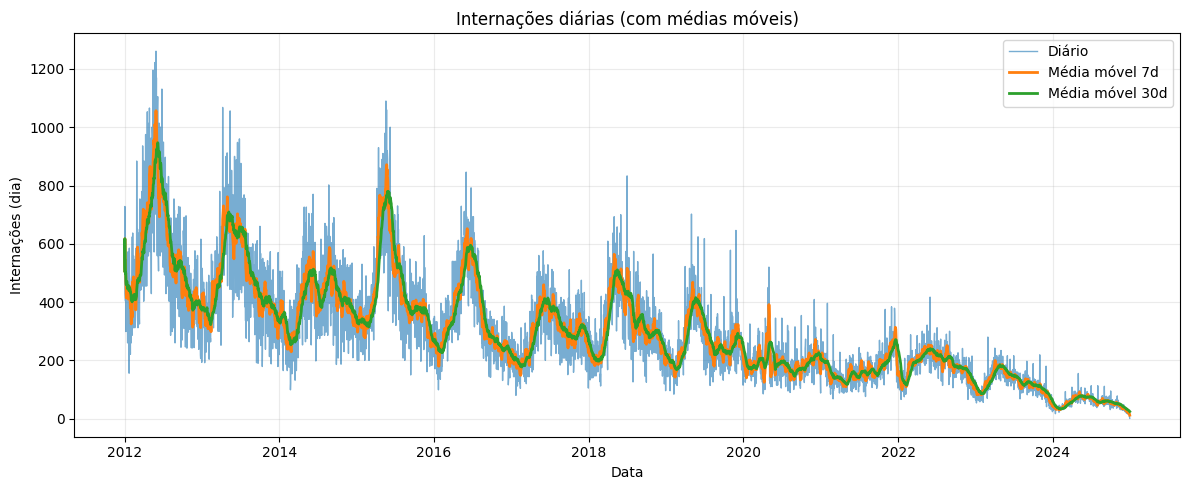

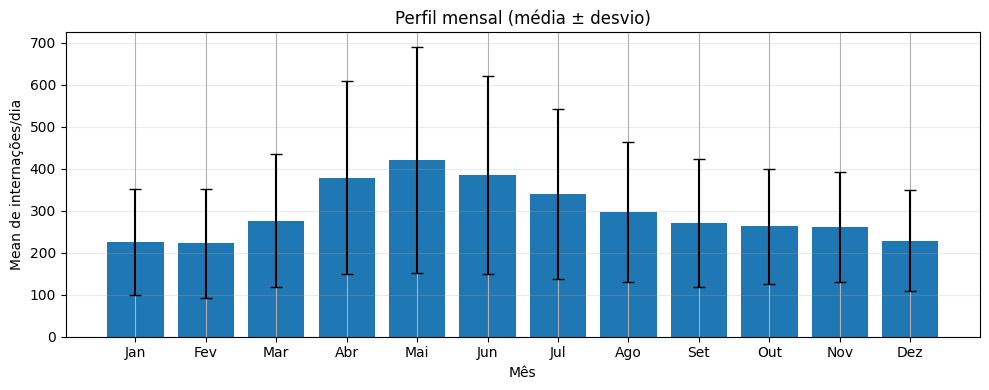

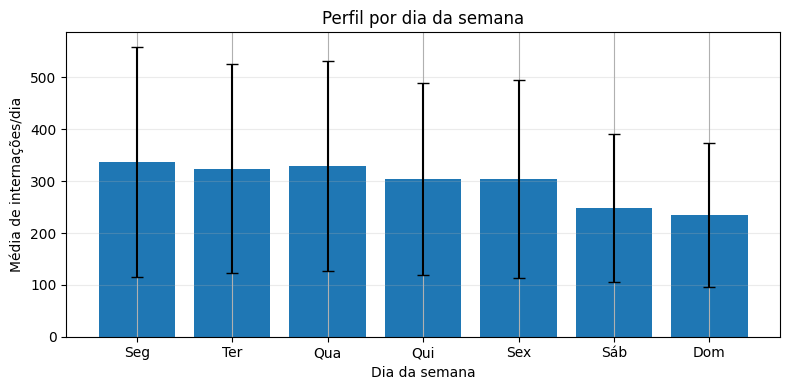

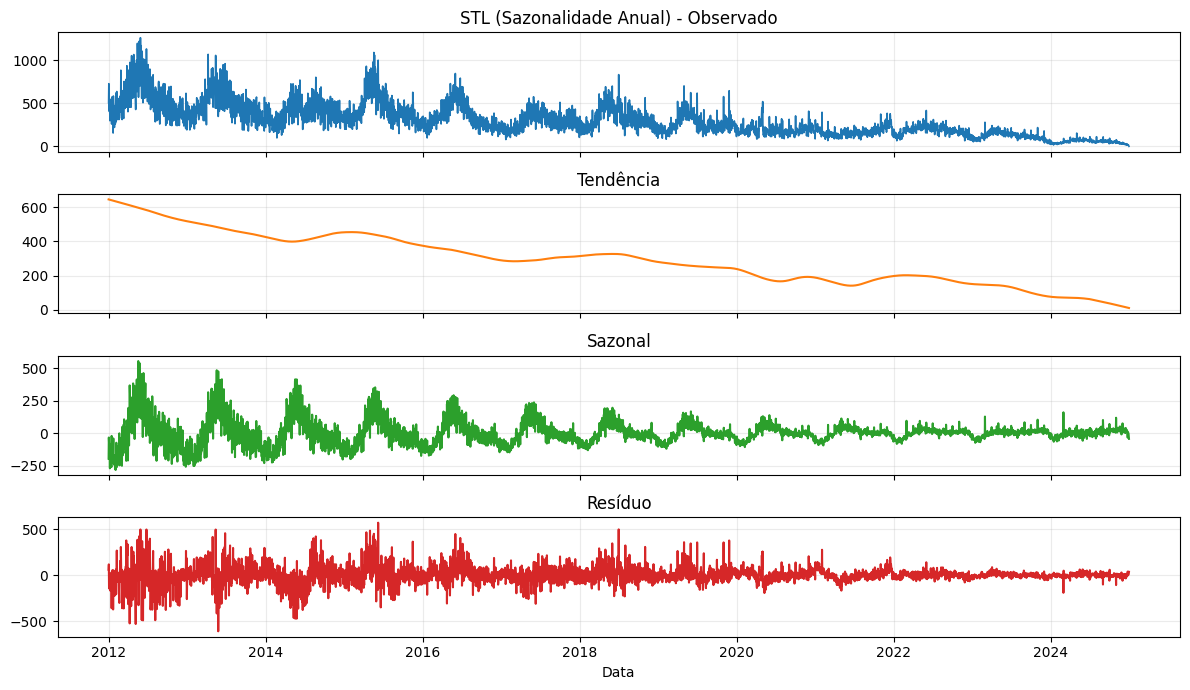

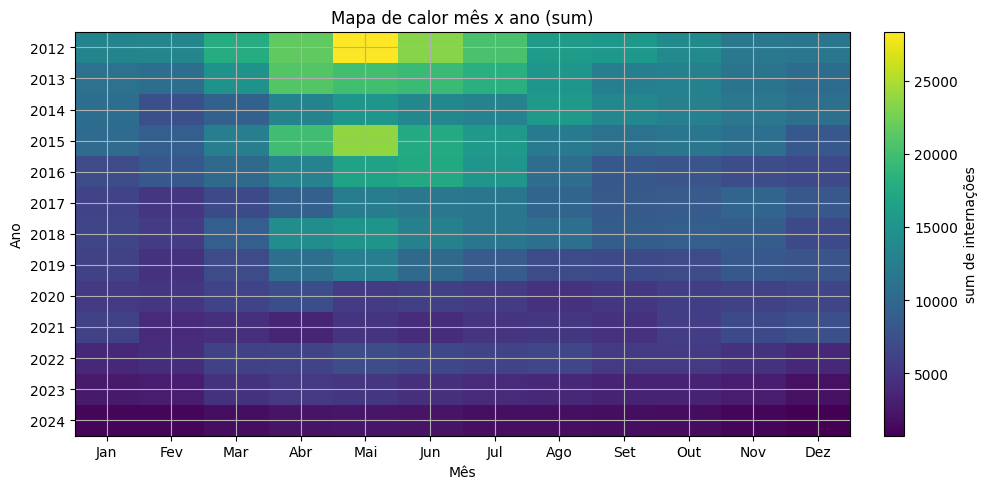

In [40]:
_PT_MONTHS = {
    1:"Jan",2:"Fev",3:"Mar",4:"Abr",5:"Mai",6:"Jun",
    7:"Jul",8:"Ago",9:"Set",10:"Out",11:"Nov",12:"Dez"
}
_PT_DOW = {0:"Seg",1:"Ter",2:"Qua",3:"Qui",4:"Sex",5:"Sáb",6:"Dom"}

def prepare_internacoes(
    df: pd.DataFrame,
    date_col: str = "data_dia",
    value_col: str = "num_internacoes"
) -> pd.DataFrame:
    """
    Prepara a série diária de internações para análise de sazonalidade.

    - Converte a coluna de data para datetime;
    - Ordena e coloca como índice;
    - Reamostra para frequência diária (D) garantindo dias ausentes;
    - Cria médias móveis (7 e 30 dias) e colunas de calendário (mês/ano/dia da semana).

    Parâmetros
    ----------
    df : DataFrame com pelo menos [date_col, value_col]
    date_col : nome da coluna de data (ex.: "data_dia")
    value_col : nome da coluna do valor (ex.: "num_internacoes")

    Retorna
    -------
    DataFrame indexado por data diária com colunas: value_col, rolling_7, rolling_30,
    year, month, month_name, dow, dow_name.
    """
    out = df.copy()
    out[date_col] = pd.to_datetime(out[date_col], errors="coerce")
    out = out[[date_col, value_col]].dropna().sort_values(date_col)
    out = out.set_index(date_col)

    # reamostra para diário (preenche faltantes)
    out = out.asfreq("D")

    # features de calendário e médias móveis
    out["rolling_7"]  = out[value_col].rolling(7, min_periods=1).mean()
    out["rolling_30"] = out[value_col].rolling(30, min_periods=1).mean()
    out["year"]  = out.index.year
    out["month"] = out.index.month
    out["month_name"] = out["month"].map(_PT_MONTHS)
    out["dow"]   = out.index.day_of_week
    out["dow_name"] = out["dow"].map(_PT_DOW)
    return out

# Série diária + médias móveis
def plot_daily_series(
    df_daily: pd.DataFrame,
    value_col: str = "num_internacoes",
    figsize=(12,5),
    title: str = "Internações diárias (com médias móveis)"
) -> None:
    """
    Plota a série diária de internações com médias móveis de 7 e 30 dias.

    Parâmetros
    ----------
    df_daily : DataFrame já preparado por prepare_internacoes (índice diário)
    value_col : coluna do valor (ex.: "num_internacoes")
    figsize : tamanho da figura
    title : título do gráfico
    """
    plt.figure(figsize=figsize)
    plt.plot(df_daily.index, df_daily[value_col], lw=1, label="Diário", alpha=0.6)
    plt.plot(df_daily.index, df_daily["rolling_7"], lw=2, label="Média móvel 7d")
    plt.plot(df_daily.index, df_daily["rolling_30"], lw=2, label="Média móvel 30d")
    plt.title(title)
    plt.xlabel("Data")
    plt.ylabel("Internações (dia)")
    plt.grid(True, alpha=0.25)
    plt.legend()
    plt.tight_layout()
    plt.show()

# Perfil sazonal mensal
def plot_monthly_profile(
    df_daily: pd.DataFrame,
    value_col: str = "num_internacoes",
    agg: str = "mean",
    figsize=(10,4),
    title: str = "Perfil mensal (média ± desvio)"
) -> None:
    """
    Mostra o perfil sazonal por MÊS (média por mês ao longo dos anos).
    Exibe barras da média e barras-de-erro com desvio-padrão.

    Parâmetros
    ----------
    df_daily : DataFrame diário preparado
    value_col : coluna do valor
    agg : agregação principal ("mean" recomendado)
    figsize : tamanho da figura
    title : título
    """
    grp = df_daily.groupby("month")[value_col]
    means = grp.mean()
    stds  = grp.std()

    months = [ _PT_MONTHS[m] for m in range(1,13) ]
    y = [means.get(m, np.nan) for m in range(1,13)]
    e = [stds.get(m, np.nan)  for m in range(1,13)]

    plt.figure(figsize=figsize)
    x = np.arange(12)
    plt.bar(x, y, yerr=e, capsize=4)
    plt.xticks(x, months)
    plt.title(title)
    plt.xlabel("Mês")
    plt.ylabel(f"{agg.capitalize()} de internações/dia")
    plt.grid(axis="y", alpha=0.25)
    plt.tight_layout()
    plt.show()

# Perfil por dia da semana
def plot_weekday_profile(
    df_daily: pd.DataFrame,
    value_col: str = "num_internacoes",
    figsize=(8,4),
    title: str = "Perfil por dia da semana"
) -> None:
    """
    Mostra o perfil médio de internações por DIA DA SEMANA (Seg..Dom).

    Parâmetros
    ----------
    df_daily : DataFrame diário preparado
    value_col : coluna do valor
    figsize : tamanho da figura
    title : título
    """
    grp = df_daily.groupby("dow")[value_col]
    means = grp.mean()
    stds  = grp.std()

    x = np.arange(7)
    labels = [_PT_DOW[i] for i in x]
    y = [means.get(i, np.nan) for i in x]
    e = [stds.get(i, np.nan)  for i in x]

    plt.figure(figsize=figsize)
    plt.bar(x, y, yerr=e, capsize=4)
    plt.xticks(x, labels)
    plt.title(title)
    plt.xlabel("Dia da semana")
    plt.ylabel("Média de internações/dia")
    plt.grid(axis="y", alpha=0.25)
    plt.tight_layout()
    plt.show()



# Decomposição sazonal (STL)
def plot_stl_decomposition(
    df_daily: pd.DataFrame,
    value_col: str = "num_internacoes",
    period: int = 365,
    loess: int = 13,
    log_transform: bool = False,
    figsize=(12,7),
    title_prefix: str = "STL (Sazonalidade Anual)"
) -> None:
    """
    Aplica STL para decompor a série em Observado, Tendência, Sazonal, Resíduo.

    Observações:
    - 'period' em dias. Para sazonalidade anual use 365 (ou 365/366).
      Para sazonalidade semanal, use 7.
    - Se a variância cresce com o nível da série, pode-se usar log_transform=True.

    Parâmetros
    ----------
    df_daily : DataFrame diário preparado
    value_col : coluna do valor
    period : período da sazonalidade (ex.: 365 para anual, 7 para semanal)
    loess : tamanho da janela LOESS usada pela STL (parâmetro 'seasonal' e 'trend' default)
    log_transform : se True, aplica log1p antes da decomposição
    figsize : tamanho da figura
    title_prefix : prefixo do título
    """
    y = df_daily[value_col].copy()
    if log_transform:
        y = np.log1p(y)

    period = int(period)
    seas_win = int(loess)
    if seas_win < 7:
        seas_win = 7
    if seas_win % 2 == 0:
        seas_win += 1

    trend_win = period + 2  # garante > period
    if trend_win % 2 == 0:
        trend_win += 1

    stl = STL(y, period=period, seasonal=seas_win, trend=trend_win, robust=True).fit()
    
    
    obs = y
    trend = stl.trend
    seas = stl.seasonal
    resid = stl.resid

    fig, axes = plt.subplots(4, 1, figsize=figsize, sharex=True)
    axes[0].plot(obs, lw=1.2);        axes[0].set_title(f"{title_prefix} - Observado")
    axes[1].plot(trend, color="C1");  axes[1].set_title("Tendência")
    axes[2].plot(seas, color="C2");   axes[2].set_title("Sazonal")
    axes[3].plot(resid, color="C3");  axes[3].set_title("Resíduo")
    for ax in axes: ax.grid(True, alpha=0.25)
    axes[-1].set_xlabel("Data")
    fig.tight_layout()
    plt.show()

# Heatmap mês × ano
def plot_month_year_heatmap(
    df_daily: pd.DataFrame,
    value_col: str = "num_internacoes",
    agg: str = "sum",
    figsize=(10,5),
    title: str = "Mapa de calor mês x ano"
) -> None:
    """
    Mostra um heatmap simples de MÊSxANO agregando a série (soma ou média).

    Parâmetros
    ----------
    df_daily : DataFrame diário preparado
    value_col : coluna do valor
    agg : "sum" (total por mês) ou "mean" (média diária do mês)
    figsize : tamanho da figura
    title : título do gráfico
    """
    if agg not in {"sum","mean"}:
        raise ValueError("agg deve ser 'sum' ou 'mean'.")

    monthly = getattr(df_daily[value_col].groupby([df_daily["year"], df_daily["month"]]), agg)()
    table = monthly.unstack(level=1).reindex(columns=range(1,13))
    table.columns = [_PT_MONTHS[m] for m in table.columns]

    plt.figure(figsize=figsize)
    im = plt.imshow(table.values, aspect="auto")
    plt.colorbar(im, fraction=0.046, pad=0.04, label=f"{agg} de internações")
    plt.yticks(ticks=np.arange(table.shape[0]), labels=table.index)
    plt.xticks(ticks=np.arange(12), labels=table.columns)
    plt.title(title + f" ({agg})")
    plt.xlabel("Mês")
    plt.ylabel("Ano")
    plt.tight_layout()
    plt.show()

def run_seasonality_eda(
    internacoes_rj: pd.DataFrame,
    date_col: str = "data_dia",
    value_col: str = "num_internacoes"
) -> pd.DataFrame:
    """
    Executa uma EDA rápida de sazonalidade:
    - Prepara a série;
    - Mostra série com médias móveis;
    - Perfil mensal;
    - Perfil por dia da semana;
    - STL anual (period=365);
    - Heatmap mêsxano (soma).

    Retorna o DataFrame diário preparado (para usos posteriores).
    """
    df = prepare_internacoes(internacoes_rj, date_col, value_col)

    plot_daily_series(df, value_col)
    plot_monthly_profile(df, value_col, agg="mean")
    plot_weekday_profile(df, value_col)
    plot_stl_decomposition(df, value_col, period=365, loess=13, log_transform=False)
    plot_month_year_heatmap(df, value_col, agg="sum")

    return df

df_prep = run_seasonality_eda(internacoes_rj)


In [41]:
def slope_tendencia_por_ano(df, date_col="data_dia", value_col="num_internacoes", period=365):
    s = df.copy()
    s[date_col] = pd.to_datetime(s[date_col])
    s = s.set_index(date_col).asfreq("D")
    y = s[value_col]

    stl = STL(y, period=period, seasonal=13, trend=period+3 if (period+3)%2 else period+4, robust=True).fit()
    trend = stl.trend
    tmp = trend.to_frame("trend")
    tmp["ano"] = tmp.index.year

    # regressão simples trend ~ t em cada ano (slope/dia => *365 ≈ slope/ano)
    out = []
    for ano, g in tmp.groupby("ano"):
        t = np.arange(len(g), dtype=float)
        if len(g) < 30:  # ignora anos muito curtos
            continue
        # mínimos quadrados: slope = cov(t,y)/var(t)
        yv = g["trend"].values
        slope_day = np.cov(t, yv, ddof=0)[0,1] / np.var(t)
        out.append({"ano": int(ano), "slope_dia": slope_day, "slope_ano": slope_day*365})
    return pd.DataFrame(out).sort_values("ano")

# Exemplo:
slopes = slope_tendencia_por_ano(internacoes_rj)
display(slopes)

,ano,slope_dia,slope_ano
0,2012,-0.363812,-132.791447
1,2013,-0.252717,-92.241743
2,2014,0.126185,46.057638
3,2015,-0.246231,-89.874268
4,2016,-0.241166,-88.025752
5,2017,0.094044,34.326072
6,2018,-0.105282,-38.428053
7,2019,-0.099737,-36.404136
8,2020,-0.112918,-41.215084
9,2021,0.053786,19.631862


In [42]:
def estacionalidade_por_ano(df, date_col="data_dia", value_col="num_internacoes", period=365):
    s = df.copy()
    s[date_col] = pd.to_datetime(s[date_col])
    s = s.set_index(date_col).asfreq("D")
    y = s[value_col]

    stl = STL(y, period=period, seasonal=13, trend=period+3 if (period+3)%2 else period+4, robust=True).fit()
    comp = pd.DataFrame({
        "y": y,
        "seasonal": stl.seasonal,
        "resid": stl.resid
    })
    comp["ano"] = comp.index.year

    # Força sazonal (Hyndman): 1 - Var(resid) / Var(seasonal + resid)
    res = []
    for ano, g in comp.groupby("ano"):
        if len(g) < 90:  # precisa de um mínimo de pontos
            continue
        var_res = np.var(g["resid"])
        var_s_r = np.var(g["seasonal"] + g["resid"])
        strength = 1 - (var_res / var_s_r) if var_s_r > 0 else np.nan
        amp = g["seasonal"].max() - g["seasonal"].min()  # amplitude anual
        res.append({"ano": int(ano), "forca_sazonal": strength, "amplitude_sazonal": amp})
    return pd.DataFrame(res).sort_values("ano")

# Exemplo:
saz = estacionalidade_por_ano(internacoes_rj)
display(saz)

,ano,forca_sazonal,amplitude_sazonal
0,2012,0.475999,835.833055
1,2013,0.523010,736.754740
2,2014,0.035160,640.546296
3,2015,0.515441,551.941295
4,2016,0.524726,464.499098
5,2017,0.335494,384.804538
6,2018,0.463805,327.067394
7,2019,0.447670,287.404112
8,2020,0.166605,245.781088
9,2021,-0.283054,207.445339


### Análise de Sazonalidade das Internações Hospitalares

#### Resumo Sazonal Mensal

###### Distribuição por Mês
**Meses com Maior Volume (Picos):**
- **Maio**: 420,2 internações/dia (média)
- **Junho**: 384,2 internações/dia  
- **Abril**: 378,5 internações/dia

**Meses com Menor Volume (Vales):**
- **Fevereiro**: 222,6 internações/dia
- **Janeiro**: 225,3 internações/dia
- **Dezembro**: 228,8 internações/dia

**Amplitude:** Variação de 197,6 internações/dia entre pico e vale (≈89% acima do mínimo)

**Variabilidade (Desvio Padrão):**
- Maior volatilidade: Maio (269,6), Junho (235,3), Abril (228,8)

---

#### Padrão Semanal

**Dias Úteis vs. Fim de Semana:**
- **Dias úteis**: Volume significativamente maior
  - Segunda a Quarta: Picos (330-340 internações/dia)
  - Quinta e Sexta: Leve redução (300-310 internações/dia)

- **Fim de semana**: Queda pronunciada
  - Sábado: ≈250 internações/dia (25% abaixo dos picos)
  - Domingo: ≈235 internações/dia (30% abaixo dos picos)

**Variabilidade:**
- Maior volatilidade nos dias úteis (Seg-Qui)
- Finais de semana mais estáveis (menor dispersão)

**Interpretação:** Padrão típico de "efeito fim de semana" - redução de procedimentos eletivos e fluxo de pacientes.

---

#### Decomposição STL (Sazonal-Tendência-Resíduo)

###### Série Observada
- **2012-2014**: Picos intensos com ciclos anuais bem definidos
- **2015-2024**: Redução progressiva na amplitude das oscilações
- **2023-2024**: Valores mais baixos e estáveis

###### Tendência (Longo Prazo)
- **Queda contínua** desde 2012
- **Queda acentuada em 2020** (impacto da pandemia)
- **Declínio sustentado** até valores mínimos em 2024
- Pequenas recuperações em 2014, 2017 e 2021

###### Componente Sazonal (Ciclos Anuais)
- **Padrão preservado**: Picos no outono/inverno (Abril-Junho)
- **Amplitude reduzida**: De ±300 (2012) para ±50-100 (2023)
- **Intensidade diminuída**: Mesmo padrão, menor magnitude

###### Resíduos (Ruído)
- **Variância decrescente**: Maior dispersão até 2015
- **Estabilização**: Menor volatilidade nos anos recentes
- **Bom ajuste**: Tendência + sazonal explicam melhor a variação recente

---

#### Métricas Anuais de Tendência e Sazonalidade

###### Tendência Anual (Slope_Ano)
- **Queda predominante**: Maioria dos anos com slope negativo
- **Principais declínios**: 
  - 2012: -133/ano
  - 2015: -90/ano  
  - 2016: -88/ano
  - 2023: -83/ano
  - 2024: -65/ano

###### Sazonalidade por Ano
- **Amplitude reduzida**: De 836 (2012) para 202 (2023) - redução de 76%
- **Força variável**:
  - 2012-2013: Forte (0,48-0,52)
  - 2014: Colapso (0,04)
  - 2015-2016: Retomada (0,52)
  - 2017-2020: Enfraquecimento (0,17 em 2020)
  - 2021: Padrão disruptivo (-0,28)
  - 2022-2023: Fortalecimento (0,59-0,64) com amplitude reduzida

---

####  Conclusões Principais

1. **Queda Estrutural**: Tendência de declínio consistente desde 2012
2. **Padrão Sazonal Preservado**: Mesmo ciclo anual (outono/inverno alto)
3. **Amplitude Reduzida**: Mesmo padrão, menor intensidade
4. **Estabilização Recente**: Menor volatilidade e melhor ajuste do modelo
5. **Efeito Fim de Semana**: Redução consistente nos finais de semana

> **Nota**: A pandemia de 2020 acelerou tendências preexistentes de queda, com recuperação parcial do padrão sazonal nos anos recentes, porém em patamares absolutos mais baixos.

## Gerando dataframe final com as novas features

In [51]:
def prepare_series(
    df: pd.DataFrame,
    date_col: str = "data_dia",
    value_col: str = "num_internacoes"
) -> pd.DataFrame:
    """
    Prepara a série diária de internações:
    - Converte data para datetime e ordena;
    - Reamostra para frequência diária (asfreq('D'));
    - Preenche faltantes (linear, ffill, bfill ou zero).
    Retorna DataFrame com a coluna 'data_dia' e 'y' (valor alvo).
    """
    s = df[[date_col, value_col]].copy()
    s[date_col] = pd.to_datetime(s[date_col], errors="coerce")
    s = s.dropna().sort_values(date_col)
    
    # Cria um índice temporal completo para reamostragem
    date_range = pd.date_range(
        start=s[date_col].min(),
        end=s[date_col].max(),
        freq='D'
    )
    
    # Cria DataFrame com todas as datas
    full_df = pd.DataFrame({date_col: date_range})
    
    # Faz merge para incluir todas as datas
    s = full_df.merge(s, on=date_col, how='left')
    
    # Preenche valores faltantes (você pode ajustar o método conforme necessário)
    s[value_col] = s[value_col].interpolate(method='linear').fillna(0)
    
    s = s.rename(columns={value_col: "y"})
    return s


# FEATURES DE CALENDÁRIO (ciclos anual e semanal)
def add_calendar_features(df: pd.DataFrame, date_col: str = "data_dia") -> pd.DataFrame:
    """
    Adiciona features de calendário úteis para capturar sazonalidade:
    - dummies: is_weekend (sábado/domingo)
    - seno/cosseno para ciclos: dia_da_semana, mês, dia_do_ano (ciclicidade)
    - colunas auxiliares: year, month, dow, doy
    """
    out = df.copy()
    dates = out[date_col]
    
    out["year"]  = dates.dt.year
    out["month"] = dates.dt.month
    out["dow"]   = dates.dt.dayofweek          # 0=Seg ... 6=Dom
    out["doy"]   = dates.dt.dayofyear

    # Fim de semana
    out["is_weekend"] = (out["dow"] >= 5).astype(int)

    # Ciclos periódicos (seno/cosseno):
    out["dow_sin"]   = np.sin(2*np.pi*out["dow"]/7)
    out["dow_cos"]   = np.cos(2*np.pi*out["dow"]/7)
    out["month_sin"] = np.sin(2*np.pi*out["month"]/12)
    out["month_cos"] = np.cos(2*np.pi*out["month"]/12)
    out["doy_sin"]   = np.sin(2*np.pi*out["doy"]/365.25)
    out["doy_cos"]   = np.cos(2*np.pi*out["doy"]/365.25)
    return out


# LAGS E MÉDIAS MÓVEIS
def add_lag_features(df: pd.DataFrame, date_col: str = "data_dia", lags: tuple = (1,2,3,7)) -> pd.DataFrame:
    """
    Cria lags do alvo para capturar defasagens exposição→resposta e inércia temporal.
    Padrão recomendado: 1, 2, 3 e 7 dias.
    """
    out = df.copy()
    
    # Ordena por data para garantir que os lags sejam calculados corretamente
    out = out.sort_values(date_col)
    
    for L in lags:
        out[f"y_lag_{L}"] = out["y"].shift(L)
    return out


def add_rolling_features(
    df: pd.DataFrame,
    date_col: str = "data_dia",
    windows: tuple = (7, 14, 30),
    stats: tuple = ("mean", "std")
) -> pd.DataFrame:
    """
    Cria estatísticas móveis do alvo **sem vazamento**:
    as janelas são calculadas sobre y.shift(1), isto é, usando
    apenas informações **até o dia anterior**.

    Parâmetros
    ----------
    df : DataFrame com as colunas [date_col, "y"]
    date_col : nome da coluna de data (usada só para ordenar)
    windows : tamanhos das janelas (em dias)
    stats : métricas calculadas em cada janela ("mean", "std", "min", "max", "median")

    Retorna
    -------
    DataFrame com colunas roll{W}_{stat} defasadas (sem olhar o dia corrente).
    """
    out = df.copy()

    if date_col in out.columns:
        out[date_col] = pd.to_datetime(out[date_col], errors="coerce")
        out = out.sort_values(date_col)

    # usa apenas o passado para evitar vazamento
    y_past = out["y"].shift(1)

    for w in windows:
        roll = y_past.rolling(window=w, min_periods=1)
        if "mean"   in stats: out[f"roll{w}_mean"]   = roll.mean()
        if "std"    in stats: out[f"roll{w}_std"]    = roll.std().fillna(0.0)
        if "min"    in stats: out[f"roll{w}_min"]    = roll.min()
        if "max"    in stats: out[f"roll{w}_max"]    = roll.max()
        if "median" in stats: out[f"roll{w}_median"] = roll.median()

    return out


# COMPONENTES STL (tendência e sazonal)
def add_stl_components(
    df: pd.DataFrame,
    date_col: str = "data_dia",
    period: int = 365,
    seasonal_win: int = 13,
    start: int = 365  # Novo parâmetro com valor padrão
) -> pd.DataFrame:
    """
    Extrai componentes de Tendência e Sazonalidade via STL com janela expansível.
    - 'stl_trend'  -> tendência de longo prazo (captura a queda estrutural observada)
    - 'stl_season' -> componente sazonal anual (picos outono-inverno)
    Observação: usa abordagem expansível para evitar lookahead bias.
    """
    out = df.copy()
    
    # Ordena por data (importante para a lógica expansível)
    out = out.sort_values(date_col)
    
    # Garante que o período seja pelo menos 2 para o STL funcionar
    period = max(2, int(period))
    
    # Calcula os componentes STL com janela expansível
    stl_trend, stl_season = compute_stl_expanding(
        y=out["y"], 
        period=period, 
        start=start
    )
    
    # Atribui os resultados ao DataFrame
    out["stl_trend"] = stl_trend
    out["stl_season"] = stl_season
    
    return out

# Função auxiliar mantida como estava
def compute_stl_expanding(y, period=7, start=365):
    stl_trend = np.full_like(y, fill_value=np.nan, dtype=float)
    stl_season = np.full_like(y, fill_value=np.nan, dtype=float)
    for t in range(start, len(y)):
        y_train = y.iloc[:t]  # até t-1 (porque o slice é exclusivo do fim)
        # IMPORTANTE: não incluir o ponto t
        res = STL(y_train, period=period, robust=True).fit()
        # Usamos o último valor disponível (t-1) para prever t:
        stl_trend[t]  = res.trend.iloc[-1]
        stl_season[t] = res.seasonal.iloc[-1]
    return stl_trend, stl_season


# PIPELINE: MONTA O CONJUNTO DE FEATURES
def build_features(
    internacoes_rj: pd.DataFrame,
    date_col: str = "data_dia",
    value_col: str = "num_internacoes",
    dropna_after_lags: bool = True
) -> pd.DataFrame:
    """
    Pipeline completo para criar features preditivas a partir de 'internacoes_rj':
    - Prepara série diária ('y');
    - Adiciona calendário (ciclos anual e semanal + fim de semana);
    - Adiciona lags (1,2,3,7) e estatísticas móveis (7,14,30 dias);
    - Adiciona componentes STL (tendência e sazonalidade anual);
    - Adiciona tendência temporal linear e dummies de regimes (quebras).
    Retorna DataFrame de features com 'data_dia' como coluna.
    """
    s = prepare_series(internacoes_rj, date_col, value_col)
    s = add_calendar_features(s, date_col)
    s = add_lag_features(s, date_col, lags=(1,2,3,7))
    s = add_rolling_features(s, date_col, windows=(7,14,30), stats=("mean","std"))
    s = add_stl_components(s, date_col, period=365, seasonal_win=13)

    return s

features = build_features(internacoes_rj)
features.head()

KeyboardInterrupt: 

### Dicionário de dados das *features* (internações diárias)

| Coluna         | O que significa                                                                                                       | Observações / Escala |
|---|---|---|
| **y**          | Alvo do modelo: número de **internações/dia**.                                                                         | contagem (≥0) |
| **year**       | **Ano** civil da observação.                                                                                           | inteiro (ex.: 2019) |
| **month**      | **Mês** do ano.                                                                                                        | 1–12 |
| **dow**        | **Dia da semana** (0=Seg, 6=Dom).                                                                                      | 0–6 |
| **doy**        | **Dia do ano** (conta a partir de 1º de jan).                                                                          | 1–365/366 |
| **is_weekend** | Indicador de **fim de semana** (Sáb/Dom).                                                                              | 0 ou 1 |
| **dow_sin**, **dow_cos** | Codificação **cíclica semanal** do `dow` (componentes seno e cosseno). Captura periodicidade sem “quebras”. | valores em [-1, 1] |
| **month_sin**, **month_cos** | Codificação **cíclica mensal** do `month`. Ajuda a modelar padrão anual suave.                          | [-1, 1] |
| **doy_sin**, **doy_cos** | Codificação **cíclica anual** do `doy`. Útil para sazonalidade de longo período.                             | [-1, 1] |
| **y_lag_k**    | **Defasagens** do alvo: internações de **k dias atrás** (ex.: `y_lag_1`, `y_lag_2`, `y_lag_3`, `y_lag_7`).            | mesma unidade de `y` |
| **rollW_mean** | **Média móvel** dos últimos **W dias** (inclui o dia corrente). Ex.: `roll7_mean`, `roll14_mean`, `roll30_mean`.       | suaviza nível recente |
| **rollW_std**  | **Desvio-padrão móvel** dos últimos **W dias**. Ex.: `roll7_std`, `roll14_std`, `roll30_std`.                         | mede **volatilidade** recente |
| **stl_trend**  | **Tendência** de longo prazo extraída via **STL** (período anual).                                                     | mesma unidade de `y` |
| **stl_season** | **Componente sazonal anual** da **STL** (centrado próximo de 0). **>0** indica mês “sazonalmente alto”, **<0** baixo. | mesma unidade de `y` |

> **Notas**  
> - `y_lag_k`: captura **inércia** e **efeitos defasados** (úteis p/ prever amanhã com base nos últimos dias).  
> - `rollW_*`: ajudam a modelar **nível** (médias) e **instabilidade** (std) recentes.  
> - As codificações senóide/cosseno evitam que o modelo “pense” que Dez (12) e Jan (1) estão longe — são vizinhos no ciclo.  
> - `stl_trend` e `stl_season` incorporam a **queda estrutural** e o **ciclo anual** identificados na sua análise.


In [50]:
project_root = Path().resolve().parents[2]  
output_dir = project_root / "data" / "datasus"
output_dir.mkdir(parents=True, exist_ok=True)

output_csv_path = output_dir / "INTER_DR_RJ_SEAZONALITY.csv"
features.to_csv(output_csv_path, index=False, encoding="utf-8")